# MyND Offline Processing: Data Analysis
Author: Geeling Chau<br> 
<br>
Description: Visualize power bin features<br>
Sources: 
- Ollie's Segment Speller Offline Processing Code https://github.com/ollie-d/SegSpeller/blob/master/Offline%20Processing.ipynb 
- neurodsp https://github.com/neurodsp-tools/neurodsp
- FOOOF https://fooof-tools.github.io/fooof/index.html 
- PyEEG http://pyeeg.sourceforge.net/ 


## Imports

In [1]:
from helperFunctions import *
from constants import *
from dataAnalysisFunctions import *

from statsmodels.stats.multitest import fdrcorrection

from neurodsp.plts.spectral import *

import seaborn as sns; sns.set()

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
# Create a binning interval
binning=[4, 7, 12, 30]
intervals = getIntervals(binning)

In [4]:
def getPowerRatioAvgSEM(eeg_list, num_eeg_timepoints=499, binning=binning): 
    power_ratio = [getPowerRatio(data[:num_eeg_timepoints], binning) for data in eeg_list]
    return np.mean(power_ratio, axis=0), getSEM(power_ratio)

## Data imports

In [5]:
# Load data frame and filtered_cleaned_data
# Also initialize the path and directories

filename_foldername_dict_path = "../data/most_currently_updated.pickle"
filename_foldername_dict = loadPickle(filename_foldername_dict_path)

foldername=filename_foldername_dict["foldername"]
filename=filename_foldername_dict["filename"]
print(foldername, filename)

article_results_directory = "../data/article_results/"+foldername+"/"
article_results_path = article_results_directory+filename+".pickle"

article_results_sem_directory = "../data/article_sem_results/"+foldername+"/"
article_results_sem_path = article_results_sem_directory+filename+".pickle"

dataframe_directory = "../data/dataframe/"+foldername+"/"
dataframe_path = dataframe_directory+filename+".pickle"

states_df_directory = "../data/states_df/"+foldername+"/"
states_df_path = states_df_directory+filename+".pickle"

ustatistic_directory = "../data/ustatistic/"+foldername+"/"
ustatistic_path = ustatistic_directory+filename+".pickle"

pvalue_directory = "../data/pvalue/"+foldername+"/"
pvalue_path = pvalue_directory+filename+".pickle"


df = loadPickle(dataframe_path)

incorporate_matlab_data = False
if incorporate_matlab_data: 
    filtered_matlab_data_directory = "../data/filtered_matlab_data/"+foldername+"/"
    filtered_matlab_data_path = filtered_matlab_data_directory+filename+".pickle"
    filtered_matlab_data = loadPickle(filtered_matlab_data_path)
    all_data = filtered_matlab_data
    data_type = "data_matlab_extended"
else :
    filtered_cleaned_data_directory = "../data/filtered_cleaned_data/"+foldername+"/"
    filtered_cleaned_data_path = filtered_cleaned_data_directory+filename+".pickle"
    filtered_cleaned_data = loadPickle(filtered_cleaned_data_path)
    all_data = filtered_cleaned_data
    data_type= "data_extended"
    

P001 part_P001_block_S004


In [6]:
def getTimeBalanced(df1, df2, window_size=10) :
    # Returns data frames that contain equal number of elements from df1 and df2 and has them be in the nearest time intervals
    start_1 = df1.iloc[0]["data_index"]
    start_2 = df2.iloc[0]["data_index"]
    # Find minimum of the two starting indexes
    min_ind = start_1 if start_1 < start_2 else start_2
    max_ind = min_ind + window_size
    
    df1_to_return_indexes = list()
    df2_to_return_indexes = list()
    
    df1_copy = df1.copy()
    df2_copy = df2.copy()
    max_data_index = max(df1["data_index"]) if max(df1["data_index"]) > max(df2["data_index"]) else max(df2["data_index"])
    # print(max_data_index)
    while min_ind < max_data_index : 
        # get sublists
        sub_df1 = df1_copy[(df1_copy["data_index"] >= min_ind) & (df1_copy["data_index"] < max_ind)]
        sub_df2 = df2_copy[(df2_copy["data_index"] >= min_ind) & (df2_copy["data_index"] < max_ind)]

        # if any of the sub lists are empty, increment min index
        if (len(sub_df1) == 0) or (len(sub_df2) == 0): 
            min_ind += 1
        else :
            # Otherwise, continue poping from both lists until one is empty, by which you increase min_index to after the numbers just added
            df1_to_add = sub_df1.iloc[0]["data_index"]
            df2_to_add = sub_df2.iloc[0]["data_index"]
            while not((len(sub_df1) == 0) or (len(sub_df2) == 0)): 
                df1_to_add = sub_df1.iloc[0]["data_index"]
                df2_to_add = sub_df2.iloc[0]["data_index"]

                df1_to_return_indexes.append(df1_to_add)
                df2_to_return_indexes.append(df2_to_add)

                sub_df1 = sub_df1[sub_df1["data_index"] != df1_to_add]
                sub_df2 = sub_df2[sub_df2["data_index"] != df2_to_add]
                df1_copy = df1_copy[df1_copy["data_index"] != df1_to_add]
                df2_copy = df2_copy[df2_copy["data_index"] != df2_to_add]

            min_ind += 1

        max_ind = min_ind + window_size
    # print(df1_to_return_indexes)
    return df1[df1["data_index"].isin(df1_to_return_indexes)], df2[df2["data_index"].isin(df2_to_return_indexes)]



In [7]:
def getFocusedPeriods(unfocused_state, num_trials_wide=10):
    # Don't need this, but it basically flips the selection to select for focus periods instead of unfocus
    focus_indexes = set()
    prev_cursor = 0
    for i, state in enumerate(unfocused_state) :
        if state: 
            prev_cursor = i+1 
        else :
            if i - prev_cursor > num_trials_wide: 
                # Add the middle of the focus period to the focus_indexes
                focus_indexes.add(prev_cursor + (num_trials_wide // 2)) 
                prev_cursor = i
    
    to_return = [False] * len(unfocused_state)
    for i, state in enumerate(unfocused_state) :
        if i in focus_indexes :
            to_return[i] = True
    return to_return

In [8]:
# Get the focus vs unfocus of alpha vs theta vs beta


# Get sections
numSections = getNumSections(filtered_cleaned_data)


if True: #not os.path.isfile(pvalue_path):

    article_results = {}
    article_sem_results = {}
    states = {}
    states["timepoint"] = list()
    states["article_num_before_after"] = list()
    states["times"] = list()

    mann_whitney_pvalue_results = {}
    mann_whitney_ustatistic_results = {}

    for article in range(1, numSections+1):
#         if article == 2:
#             continue # do not include the second article for P008 Long
        df_article = df[df["section_number"] == article]

        article_results[article] = {}
        article_results[article]["focus"] = {}
        article_results[article]["focus"]["alpha"] = list()
        article_results[article]["focus"]["theta"] = list()
        article_results[article]["focus"]["beta"] = list()

        article_results[article]["unfocus"] = {}
        article_results[article]["unfocus"]["alpha"] = list()
        article_results[article]["unfocus"]["theta"] = list()
        article_results[article]["unfocus"]["beta"] = list()


        article_sem_results[article] = {}
        article_sem_results[article]["focus"] = {}
        article_sem_results[article]["focus"]["alpha"] = list()
        article_sem_results[article]["focus"]["theta"] = list()
        article_sem_results[article]["focus"]["beta"] = list()

        article_sem_results[article]["unfocus"] = {}
        article_sem_results[article]["unfocus"]["alpha"] = list()
        article_sem_results[article]["unfocus"]["theta"] = list()
        article_sem_results[article]["unfocus"]["beta"] = list()
        
        
        mann_whitney_pvalue_results[article] = list()
        mann_whitney_ustatistic_results[article] = list()
        
        for i in range(len(intervals)) :
            mann_whitney_pvalue_results[article].append(list())
            mann_whitney_ustatistic_results[article].append(list())
        
        
        for num_before in range(10):

            article_results[article]["focus"]["alpha"].append(list())
            article_results[article]["focus"]["theta"].append(list())
            article_results[article]["focus"]["beta"].append(list())

            article_results[article]["unfocus"]["alpha"].append(list())
            article_results[article]["unfocus"]["theta"].append(list())
            article_results[article]["unfocus"]["beta"].append(list())

            article_sem_results[article]["focus"]["alpha"].append(list())
            article_sem_results[article]["focus"]["theta"].append(list())
            article_sem_results[article]["focus"]["beta"].append(list())

            article_sem_results[article]["unfocus"]["alpha"].append(list())
            article_sem_results[article]["unfocus"]["theta"].append(list())
            article_sem_results[article]["unfocus"]["beta"].append(list())
            
            # Initialize interval lists corresponding to interval bins
            for i in range(len(intervals)) :
                mann_whitney_pvalue_results[article][i].append(list())
                mann_whitney_ustatistic_results[article][i].append(list())

            print(num_before)

            for num_after in range(10): 
                #unfocused_state = list(((df_article["is_pressed"] == False) & (df_article["is_target"] == True)) | ((df_article["is_pressed"] == True) & (df_article["is_target"] == False)))
                # unfocused_state = getSmoothedPerformance(unfocused_state, num_before, num_after)
                
                focused_state = getSmoothedPerformance(list(df_article["trial_time"] == 0.7), num_before, num_after)
                for i, state in enumerate(focused_state):
                    states["timepoint"].append(i)
                    states["article_num_before_after"].append((article, num_before, num_after))
                    states["times"].append(state)


                #print(unfocused_state)
                unfocused_df = df_article[np.logical_not(focused_state)]
                focused_df = df_article[focused_state]

                if(len(unfocused_df) == 0 or len(focused_df) == 0) :
                    article_results[article]["focus"]["alpha"][num_before].append(0)
                    article_results[article]["focus"]["theta"][num_before].append(0)
                    article_results[article]["focus"]["beta"][num_before].append(0)

                    article_results[article]["unfocus"]["alpha"][num_before].append(0)
                    article_results[article]["unfocus"]["theta"][num_before].append(0)
                    article_results[article]["unfocus"]["beta"][num_before].append(0)

                    article_sem_results[article]["focus"]["alpha"][num_before].append(0)
                    article_sem_results[article]["focus"]["theta"][num_before].append(0)
                    article_sem_results[article]["focus"]["beta"][num_before].append(0)

                    article_sem_results[article]["unfocus"]["alpha"][num_before].append(0)
                    article_sem_results[article]["unfocus"]["theta"][num_before].append(0)
                    article_sem_results[article]["unfocus"]["beta"][num_before].append(0)
                    
                    for i in range(len(intervals)) :
                        mann_whitney_pvalue_results[article][i][num_before].append(0)
                        mann_whitney_ustatistic_results[article][i][num_before].append(0)
                else : 
                    f_df, u_df = getTimeBalanced(focused_df, unfocused_df, window_size=max(2, (num_before + num_after + 5)))

#                     if(num_before == 3 and num_after == 8) :
#                         plt.figure(figsize=(20,10))
#                         plt.scatter(focused_df["data_index"].values, [1]*len(focused_df["data_index"].values))
#                         plt.scatter(unfocused_df["data_index"].values, [1]*len(unfocused_df["data_index"].values))

#                         plt.scatter(f_df["data_index"].values, [0]*len(f_df["data_index"].values))
#                         plt.scatter(u_df["data_index"].values, [0]*len(u_df["data_index"].values))

#                         plt.show()
                    
                    focused_eeg = tidyEEGList(getEEGFromDataFrame_AvgLeftRight(f_df, data_type=data_type))
                    focused_power_ratios = np.array([getPowerRatio(data, binning) for data in focused_eeg])
                    focused_power_ratio_avg = np.mean(focused_power_ratios, axis=0)
                    SEM_focused_power_ratio = getSEM(focused_power_ratios)

                
                    unfocused_eeg = tidyEEGList(getEEGFromDataFrame_AvgLeftRight(u_df, data_type=data_type))
                    unfocused_power_ratios = np.array([getPowerRatio(data, binning) for data in unfocused_eeg])
                    unfocused_power_ratio_avg = np.mean(unfocused_power_ratios, axis=0)
                    SEM_unfocused_power_ratio = getSEM(unfocused_power_ratios)
                    
                    for i in range(len(intervals)): 
                        mann_whitney = sp.stats.mannwhitneyu(focused_power_ratios[:,i], unfocused_power_ratios[:,i] )
                        mann_whitney_pvalue_results[article][i][num_before].append(mann_whitney.pvalue)
                        mann_whitney_ustatistic_results[article][i][num_before].append(mann_whitney.statistic)
                    
                    #focused_power_ratio_avg, SEM_focused_power_ratio = getPowerRatioAvgSEM(getEEGFromDataFrame_AvgLeftRight(f_df, data_type=data_type))
                    #unfocused_power_ratio_avg, SEM_unfocused_power_ratio = getPowerRatioAvgSEM(getEEGFromDataFrame_AvgLeftRight(u_df, data_type=data_type))


                    article_results[article]["focus"]["alpha"][num_before].append(focused_power_ratio_avg[2])
                    article_results[article]["focus"]["theta"][num_before].append(focused_power_ratio_avg[0])
                    article_results[article]["focus"]["beta"][num_before].append(focused_power_ratio_avg[1])

                    article_results[article]["unfocus"]["alpha"][num_before].append(unfocused_power_ratio_avg[2])
                    article_results[article]["unfocus"]["theta"][num_before].append(unfocused_power_ratio_avg[0])
                    article_results[article]["unfocus"]["beta"][num_before].append(unfocused_power_ratio_avg[1])

                    article_sem_results[article]["focus"]["alpha"][num_before].append(SEM_focused_power_ratio[2])
                    article_sem_results[article]["focus"]["theta"][num_before].append(SEM_focused_power_ratio[0])
                    article_sem_results[article]["focus"]["beta"][num_before].append(SEM_focused_power_ratio[1])

                    article_sem_results[article]["unfocus"]["alpha"][num_before].append(SEM_unfocused_power_ratio[2])
                    article_sem_results[article]["unfocus"]["theta"][num_before].append(SEM_unfocused_power_ratio[0])
                    article_sem_results[article]["unfocus"]["beta"][num_before].append(SEM_unfocused_power_ratio[1])

    # Visualize the different cases we're considering
    states_df = pd.DataFrame(states)
    
                   
else :
    article_results = loadPickle(article_results_path)
    article_sem_results = loadPickle(article_results_sem_path)
    states_df = loadPickle(states_df_path)
    mann_whitney_pvalue_results = loadPickle(pvalue_path)
    mann_whitney_ustatistic_results = loadPickle(ustatistic_path)

0
1
2
3
4
5
6
7
8
9
0
1
2
3
4
5
6
7
8
9


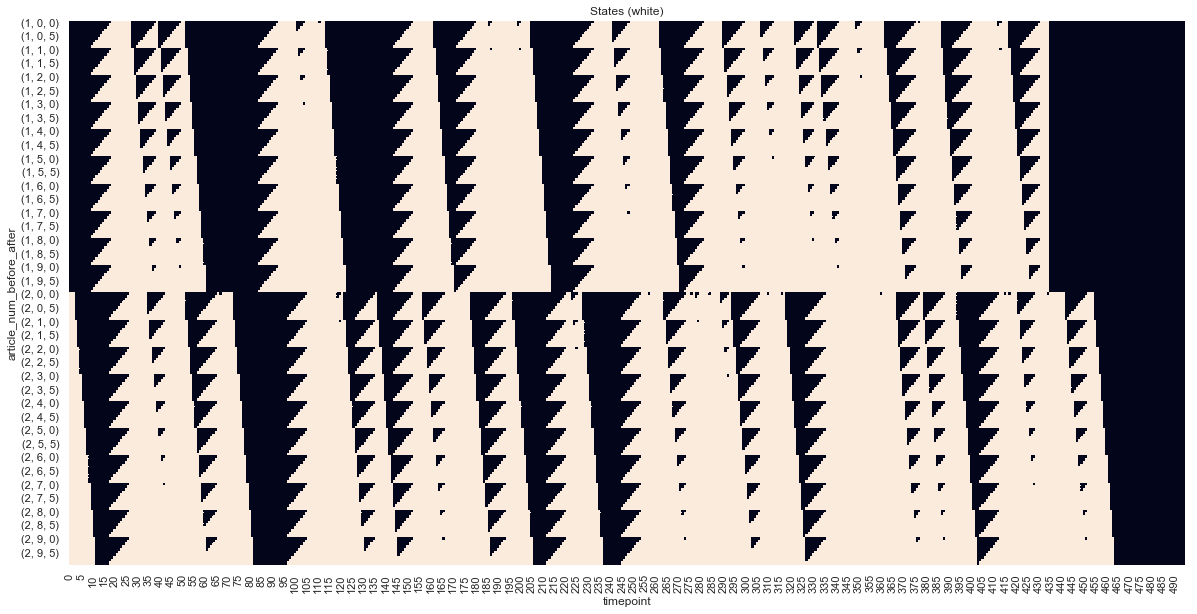

In [9]:
pivoted = states_df.pivot("article_num_before_after", "timepoint", "times")
pivoted = pivoted.fillna(False)

plt.figure(figsize=(20,10))
plt.title("States (white)")
ax = sns.heatmap(pivoted, cbar=False)  

min pvalue: 0.10835452842777782 at (array([6, 7]), array([5, 5]))


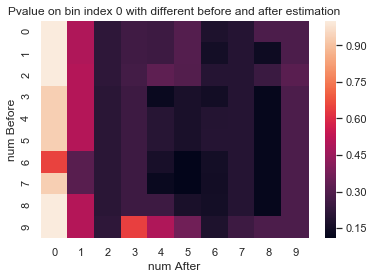

min pvalue: 0.04489517944178216 at (array([2, 3, 4, 5, 6, 7, 8, 9]), array([2, 2, 2, 2, 2, 2, 2, 2]))


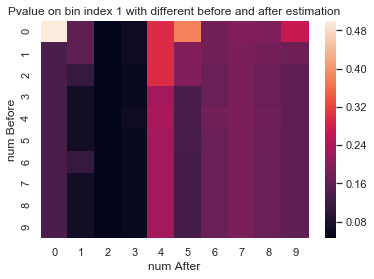

min pvalue: 0.024285480035060005 at (array([5, 8, 9]), array([4, 4, 4]))


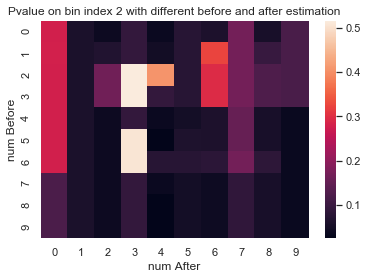

In [10]:
# mann whitney heatmaps of differences to see what is best to use
for j in range(0, len(intervals)):
    bin_index = j
    bin_mann_whitney_list = []
    for i in range(1, numSections+1):
        if i in mann_whitney_pvalue_results:
            result = np.array(mann_whitney_pvalue_results[i][bin_index])
            bin_mann_whitney_list.append(fdrcorrection(result)[1])

    # Average them to see which would actually be best
    result = np.mean(bin_mann_whitney_list, axis=0)
    print("min pvalue:",np.min(result), "at", np.where(result == np.min(result)))
    ax = sns.heatmap(result)
    plt.title("Pvalue on bin index "+str(bin_index)+" with different before and after estimation")
    plt.xlabel("num After")
    plt.ylabel("num Before")
    plt.show()



min U statistic: 1899.5 at (array([9]), array([9]))


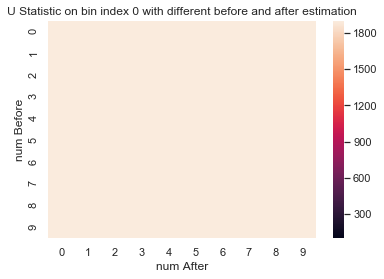

min U statistic: 1493.5 at (array([9]), array([9]))


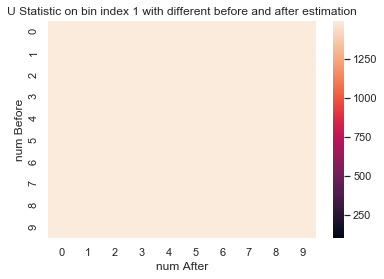

min U statistic: 1490.5 at (array([9]), array([9]))


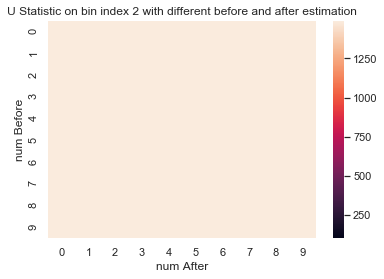

In [11]:
# mann whitney heatmaps of differences to see what is best to use
for j in range(len(intervals)):
    bin_index = j
    bin_mann_whitney_list = []
    for i in range(1, numSections+1):
        if i in mann_whitney_ustatistic_results:
            result = np.array(mann_whitney_ustatistic_results[i][bin_index])
            bin_mann_whitney_list.append(result)

    # Average them to see which would actually be best
    result = np.mean(bin_mann_whitney_list, axis=0)
    print("min U statistic:",np.min(result), "at", np.where(result == np.min(result)))
    ax = sns.heatmap(result, vmax=100)
    plt.title("U Statistic on bin index "+str(bin_index)+" with different before and after estimation")
    plt.xlabel("num After")
    plt.ylabel("num Before")
    plt.show()


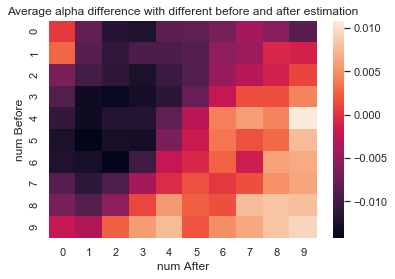

max sem accounted diff: -0.005144316622570869 at (array([0]), array([8]))


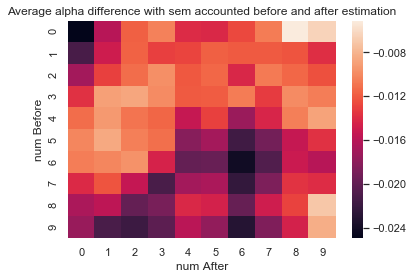

In [32]:
# Alpha heatmaps of differences to see what is best to use
average_alpha_diff_list = []
average_alpha_SEM_accounted_diff_list = []
for i in range(1, numSections+1):
    if i in article_results.keys() and len(article_results[i]["focus"]["alpha"][0])>0:
        result = np.array(article_results[i]["focus"]["alpha"]) - np.array(article_results[i]["unfocus"]["alpha"])
        average_alpha_diff_list.append(result)
        
        result_sem = np.array(article_sem_results[i]["focus"]["alpha"]) + np.array(article_sem_results[i]["unfocus"]["alpha"])
        average_alpha_SEM_accounted_diff_list.append(np.abs(result) - result_sem)
        
# Average them to see which would actually be best
result = np.mean(average_alpha_diff_list, axis=0)
ax = sns.heatmap(result)
plt.title("Average alpha difference with different before and after estimation")
plt.xlabel("num After")
plt.ylabel("num Before")
plt.show()

# Average them to see which would actually be best
result = np.mean(average_alpha_SEM_accounted_diff_list, axis=0)
print("max sem accounted diff:",np.max(result), "at", np.where(result == np.max(result)))
ax = sns.heatmap(result)
plt.title("Average alpha difference with sem accounted before and after estimation")
plt.xlabel("num After")
plt.ylabel("num Before")
plt.show()

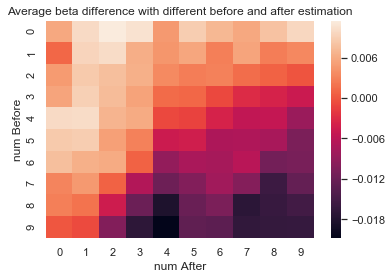

max sem accounted diff: 0.00435735608561366 at (array([3]), array([8]))


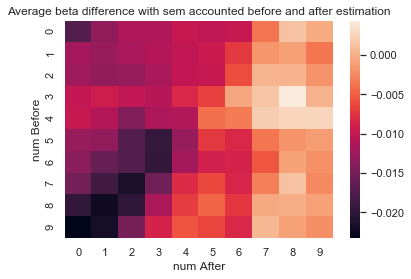

In [33]:
# Beta heatmaps of differences to see what is best to use
average_beta_diff_list = []
average_beta_SEM_accounted_diff_list = []
for i in range(1, numSections+1):
    if i in article_results.keys() and len(article_results[i]["focus"]["beta"][0])>0:
        result = np.array(article_results[i]["focus"]["beta"]) - np.array(article_results[i]["unfocus"]["beta"])
        average_beta_diff_list.append(result)
        
        result_sem = np.array(article_sem_results[i]["focus"]["beta"]) + np.array(article_sem_results[i]["unfocus"]["beta"])
        average_beta_SEM_accounted_diff_list.append(np.abs(result) - result_sem)

# Average them to see which would actually be best
result = np.mean(average_beta_diff_list, axis=0)
ax = sns.heatmap(result)
plt.title("Average beta difference with different before and after estimation")
plt.xlabel("num After")
plt.ylabel("num Before")
plt.show()


# Average them to see which would actually be best
result = np.mean(average_beta_SEM_accounted_diff_list, axis=0)
print("max sem accounted diff:",np.max(result), "at", np.where(result == np.max(result)))
ax = sns.heatmap(result)
plt.title("Average beta difference with sem accounted before and after estimation")
plt.xlabel("num After")
plt.ylabel("num Before")
plt.show()



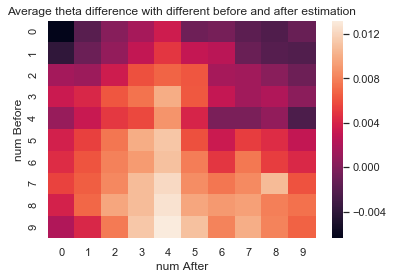

max sem accounted diff: -0.0055804651630787655 at (array([4]), array([7]))


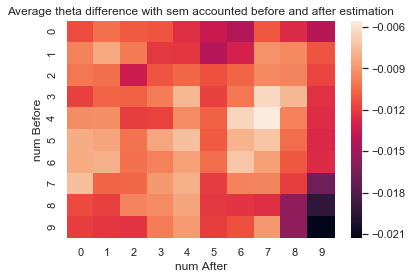

In [34]:
# Theta heatmaps of differences to see what is best to use
average_theta_diff_list = []
average_theta_SEM_accounted_diff_list = []
for i in range(1, numSections+1):
    if i in article_results.keys() and len(article_results[i]["focus"]["theta"][0])>0:
        result = np.array(article_results[i]["focus"]["theta"]) - np.array(article_results[i]["unfocus"]["theta"])
        average_theta_diff_list.append(result)
    
        result_sem = np.array(article_sem_results[i]["focus"]["theta"]) + np.array(article_sem_results[i]["unfocus"]["theta"])
        average_theta_SEM_accounted_diff_list.append(np.abs(result) - result_sem)

# Average them to see which would actually be best
result = np.mean(average_theta_diff_list, axis=0)
ax = sns.heatmap(result)
plt.title("Average theta difference with different before and after estimation")
plt.xlabel("num After")
plt.ylabel("num Before")
plt.show()


# Average them to see which would actually be best
result = np.mean(average_theta_SEM_accounted_diff_list, axis=0)
print("max sem accounted diff:",np.max(result), "at", np.where(result == np.max(result)))

ax = sns.heatmap(result)
plt.title("Average theta difference with sem accounted before and after estimation")
plt.xlabel("num After")
plt.ylabel("num Before")
plt.show()


In [35]:
import warnings
warnings.filterwarnings('ignore')

In [38]:
optimal_num_before = 6
optimal_num_after = 1
df_article=df
focused_state = list(df_article["trial_time"] == 0.7) #list(((df_article["is_pressed"] == False) & (df_article["is_target"] == True)) | ((df_article["is_pressed"] == True) & (df_article["is_target"] == False)))
focused_state = getSmoothedPerformance(focused_state, optimal_num_before, optimal_num_after)
unfocused_df = df_article[np.logical_not(focused_state)]
focused_df = df_article[focused_state]

f_df, u_df = getTimeBalanced(focused_df, unfocused_df, window_size=max(2, (optimal_num_before + optimal_num_after + 5)))

f_power_ratios = list()
for eeg_data in getEEGFromDataFrame_AvgLeftRight(f_df, data_type=data_type):
    f_power_ratios.append(getPowerRatio(eeg_data, binning))
u_power_ratios = list()
for eeg_data in getEEGFromDataFrame_AvgLeftRight(u_df, data_type=data_type):
    u_power_ratios.append(getPowerRatio(eeg_data, binning))
    
f_power_ratios = np.array(f_power_ratios)
u_power_ratios = np.array(u_power_ratios)


focus_theta_power_ratios = f_power_ratios[:, 0]
unfocus_theta_power_ratios = u_power_ratios[:, 0]

sp.stats.mannwhitneyu(focus_theta_power_ratios, unfocus_theta_power_ratios )

MannwhitneyuResult(statistic=41320.0, pvalue=0.054798171550717534)

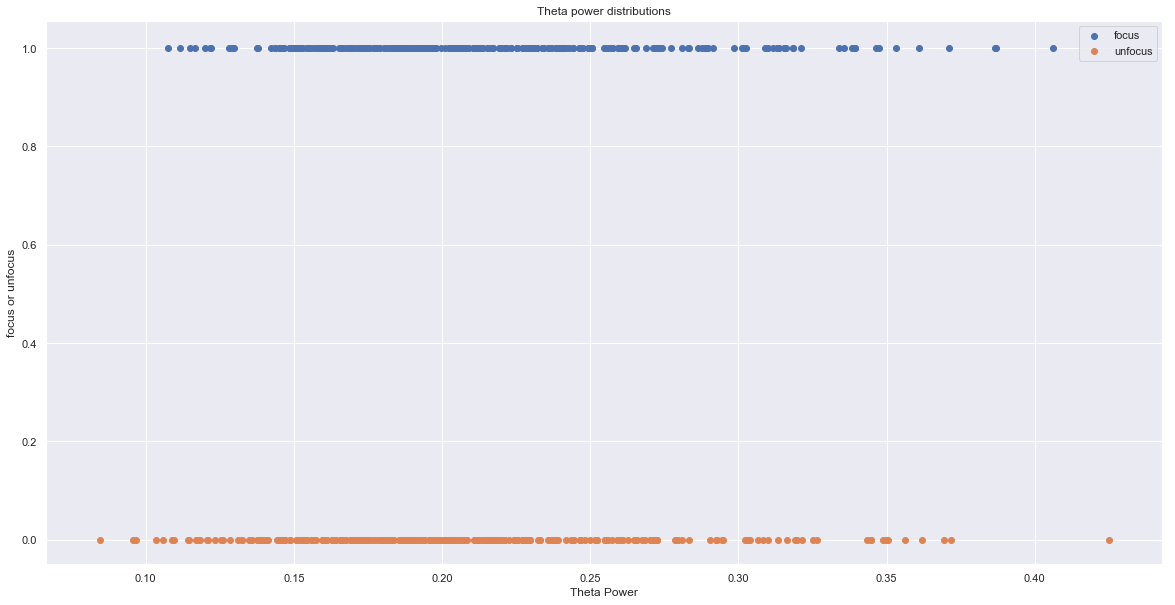

In [17]:
plt.figure(figsize=(20,10))
plt.scatter(focus_theta_power_ratios, [1] * len(focus_theta_power_ratios), label="focus")
plt.scatter(unfocus_theta_power_ratios, [0] * len(unfocus_theta_power_ratios), label="unfocus")
plt.xlabel("Theta Power")
plt.ylabel("focus or unfocus")
plt.title("Theta power distributions")
plt.legend()
plt.show()

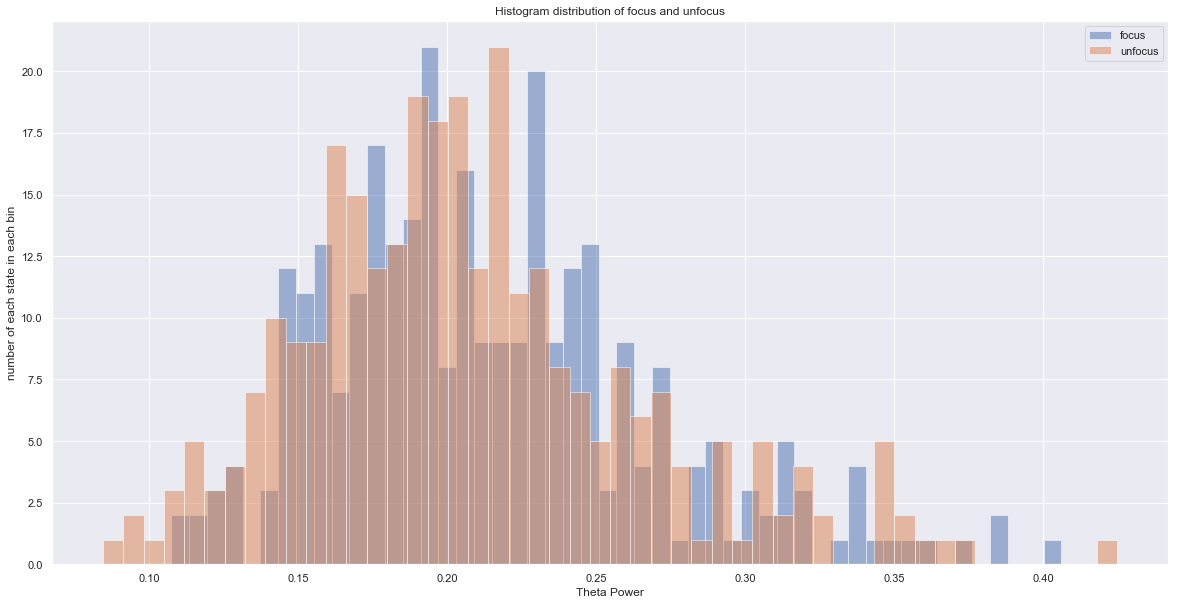

In [18]:
plt.figure(figsize=(20,10))

plt.hist(focus_theta_power_ratios, bins=50, alpha=0.5, label="focus")
plt.hist(unfocus_theta_power_ratios, bins=50, alpha=0.5, label="unfocus")
plt.xlabel("Theta Power")
plt.ylabel("number of each state in each bin")
plt.title("Histogram distribution of focus and unfocus")
plt.legend()
plt.show()

## LDA 


In [19]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA

X = np.append(f_power_ratios, u_power_ratios, axis=0)
print("num training samples", len(X))
y = np.append(np.array([1] * len(f_power_ratios)), np.array([0] * len(u_power_ratios)))

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=0)

sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)


lda = LDA()
fit = lda.fit(X_train, y_train)
y_predict = lda.predict(X_test)
lda.score(X_test, y_test)

num training samples 598


0.6333333333333333

## Plot power distributions

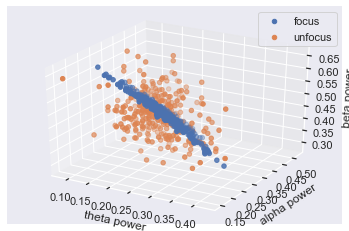

In [20]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.scatter(np.array(f_power_ratios)[:, 0], np.array(f_power_ratios)[:, 1], np.array(f_power_ratios)[:, 2], label="focus")
ax.scatter(np.array(u_power_ratios)[:, 0], np.array(u_power_ratios)[:, 1], np.array(f_power_ratios)[:, 2], label="unfocus")
plt.legend()
ax.set_xlabel("theta power")
ax.set_ylabel("alpha power")
ax.set_zlabel("beta power")
plt.show()


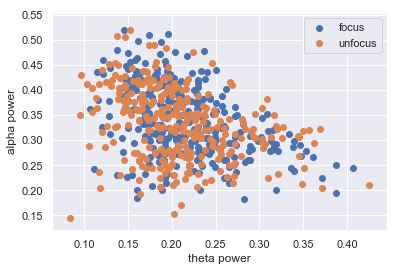

In [21]:
plt.scatter(np.array(f_power_ratios)[:, 0], np.array(f_power_ratios)[:, 1], label="focus")
plt.scatter(np.array(u_power_ratios)[:, 0], np.array(u_power_ratios)[:, 1], label="unfocus")
plt.legend()
plt.xlabel("theta power")
plt.ylabel("alpha power")
plt.show()


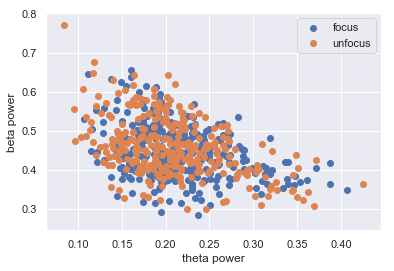

In [22]:
plt.scatter(np.array(f_power_ratios)[:, 0], np.array(f_power_ratios)[:, 2], label="focus")
plt.scatter(np.array(u_power_ratios)[:, 0], np.array(u_power_ratios)[:, 2], label="unfocus")
plt.legend()
plt.xlabel("theta power")
plt.ylabel("beta power")
plt.show()


In [23]:
x_min = np.min([np.array(u_power_ratios)[:, 0], np.array(f_power_ratios)[:, 0]])
x_max = np.max([np.array(u_power_ratios)[:, 0], np.array(f_power_ratios)[:, 0]])

y_min = np.min([np.array(u_power_ratios)[:, 2], np.array(f_power_ratios)[:, 2]])
y_max = np.max([np.array(u_power_ratios)[:, 2], np.array(f_power_ratios)[:, 2]])

x_bins = np.linspace(x_min,x_max,10)
y_bins = np.linspace(y_min,y_max,10)

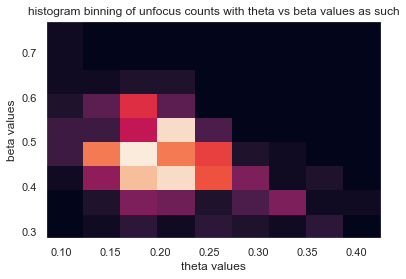

In [24]:
count_unfocus, a, b, c = plt.hist2d(np.array(u_power_ratios)[:, 0], np.array(u_power_ratios)[:, 2], bins=[x_bins,y_bins]);

plt.xlabel("theta values")
plt.ylabel("beta values")
plt.title("histogram binning of unfocus counts with theta vs beta values as such")
plt.show()


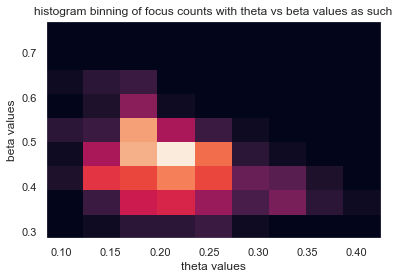

In [25]:

count_focus, af, bf, _ = plt.hist2d(np.array(f_power_ratios)[:, 0], np.array(f_power_ratios)[:, 2], bins=[x_bins,y_bins]);
plt.xlabel("theta values")
plt.ylabel("beta values")
plt.title("histogram binning of focus counts with theta vs beta values as such")
plt.show()


max theta beta diff: 9.0 at (array([2]), array([4]))
min theta beta diff: -13.0 at (array([3]), array([4]))


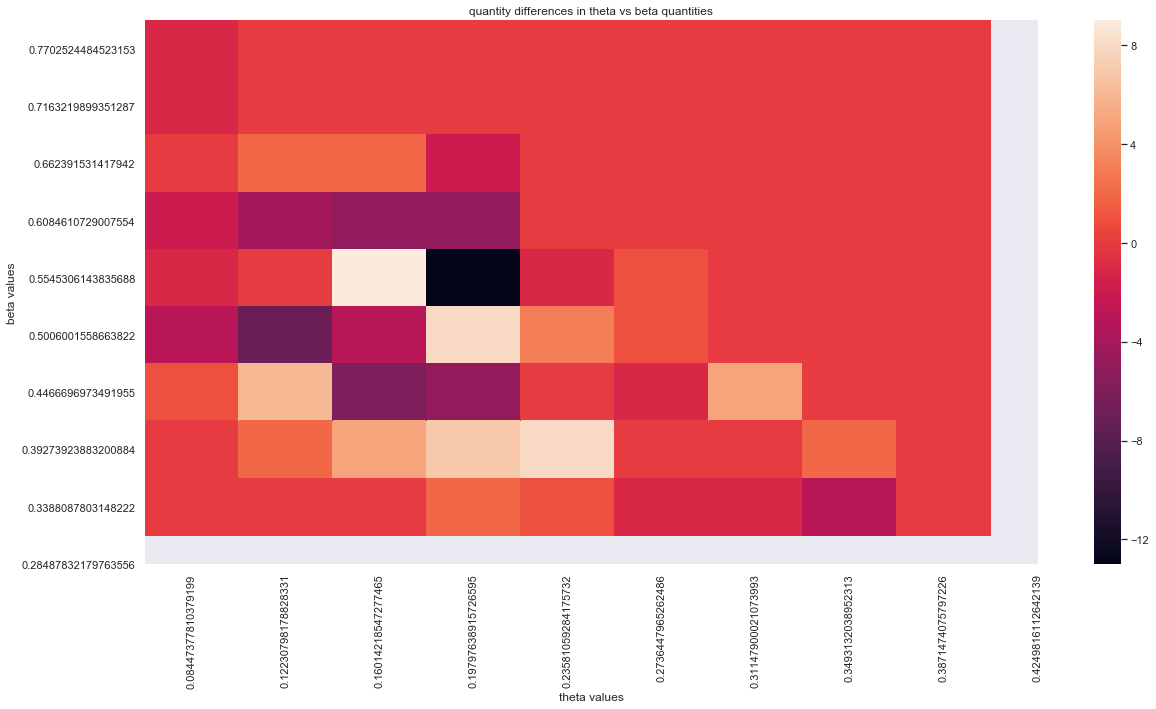

In [26]:
diff = count_focus - count_unfocus 

print("max theta beta diff:",np.max(diff), "at", np.where(diff == np.max(diff)))
print("min theta beta diff:",np.min(diff), "at", np.where(diff == np.min(diff)))


plt.figure(figsize=(20,10))
ax = sns.heatmap(np.flipud(np.transpose(diff)), xticklabels=a, yticklabels=np.flip(b))
plt.title("quantity differences in theta vs beta quantities")
plt.xlabel("theta values")
plt.ylabel("beta values")
plt.show()

## Closer look at the optimal focus model


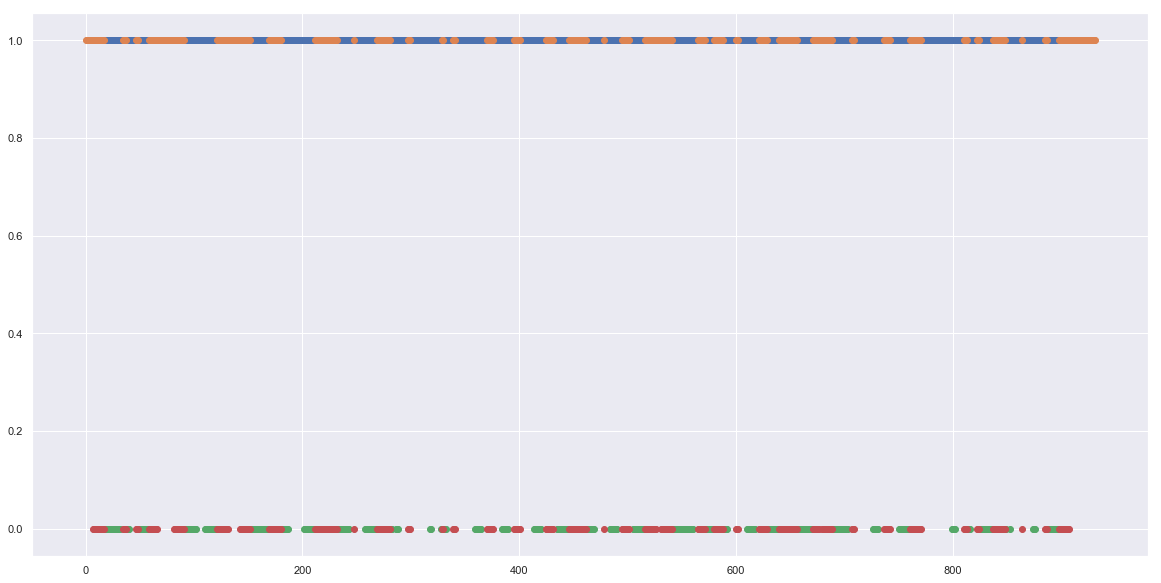

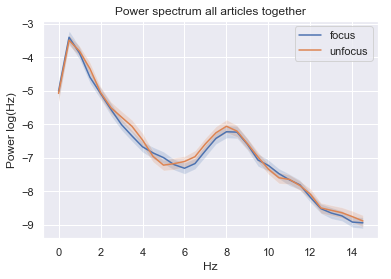

num focus 299 num unfocus 299


In [27]:

plt.figure(figsize=(20,10))
plt.scatter(focused_df["data_index"].values, [1]*len(focused_df["data_index"].values))
plt.scatter(unfocused_df["data_index"].values, [1]*len(unfocused_df["data_index"].values))

plt.scatter(f_df["data_index"].values, [0]*len(f_df["data_index"].values))
plt.scatter(u_df["data_index"].values, [0]*len(u_df["data_index"].values))

plt.show()

focused_df=f_df.copy()
unfocused_df=u_df.copy()


focused_power_ratio_avg, SEM_focused_power_ratio = getPowerRatioAvgSEM(getEEGFromDataFrame_AvgLeftRight(focused_df, data_type=data_type))
unfocused_power_ratio_avg, SEM_unfocused_power_ratio = getPowerRatioAvgSEM(getEEGFromDataFrame_AvgLeftRight(unfocused_df, data_type=data_type))


focused_freqs, focused_psds, focused_psd_avg = getFreqsAndPSD(tidyEEGList(getEEGFromDataFrame_AvgLeftRight(focused_df, data_type=data_type))) 
focused_psd_sem = getSEM(np.log(focused_psds))

unfocused_freqs, unfocused_psds, unfocused_psd_avg = getFreqsAndPSD(tidyEEGList(getEEGFromDataFrame_AvgLeftRight(unfocused_df, data_type=data_type)))
unfocused_psd_sem = getSEM(np.log(unfocused_psds))


plot_window_size = 30


freq1 = focused_freqs[:plot_window_size]
psd1 = np.log(focused_psd_avg[:plot_window_size])
sem1 = focused_psd_sem[:plot_window_size]

plt.plot(freq1, psd1, label="focus")
plt.fill_between(freq1, psd1-sem1, psd1+sem1, alpha = 0.2)

freq2 = unfocused_freqs[:plot_window_size]
psd2 = np.log(unfocused_psd_avg[:plot_window_size])
sem2 = unfocused_psd_sem[:plot_window_size]

plt.plot(freq2, psd2, label="unfocus")
plt.fill_between(freq2, psd2-sem2, psd2+sem2, alpha = 0.2)

plt.legend()
plt.title("Power spectrum all articles together")
plt.xlabel("Hz")
plt.ylabel("Power log(Hz)")
plt.show()

print("num focus", len(focused_df), "num unfocus", len(unfocused_df))

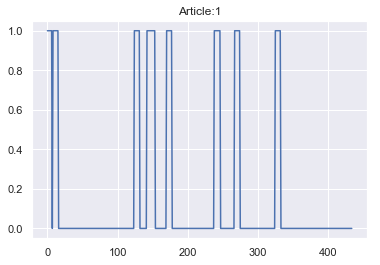

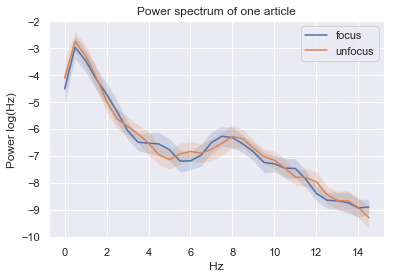

num focus 64 num unfocus 64


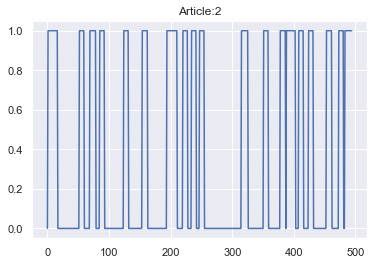

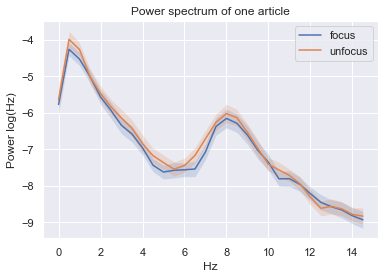

num focus 165 num unfocus 165


In [28]:
# Closer look at the optimal focus model

focus_eeg_list = list()
unfocus_eeg_list = list()

for i in range(1, numSections + 1): 
    df_article=df[df["section_number"] == i]
    unfocused_state = getSmoothedPerformance(list((df_article["is_pressed"] == False) & (df_article["is_target"] == True)), optimal_num_before, optimal_num_after)
    unfocused_df = df_article[unfocused_state]
    focused_df = df_article[np.logical_not(unfocused_state)]
    
    if (len(focused_df)==0 or len(unfocused_df)==0):
        continue
    
    
    focused_df, unfocused_df = getTimeBalanced(focused_df, unfocused_df, window_size=max(2, (optimal_num_before + optimal_num_after + 5)))

    focus_eeg_list.extend(getEEGFromDataFrame_AvgLeftRight(focused_df, data_type=data_type))
    unfocus_eeg_list.extend(getEEGFromDataFrame_AvgLeftRight(unfocused_df, data_type=data_type))
    
    plt.plot(unfocused_state)
    plt.title("Article:" + str(i))
    plt.show()
    
    
    focused_freqs, focused_psds, focused_psd_avg = getFreqsAndPSD(tidyEEGList(getEEGFromDataFrame_AvgLeftRight(focused_df, data_type=data_type))) 
    focused_psd_sem = getSEM(np.log(focused_psds))

    unfocused_freqs, unfocused_psds, unfocused_psd_avg = getFreqsAndPSD(tidyEEGList(getEEGFromDataFrame_AvgLeftRight(unfocused_df, data_type=data_type)))
    unfocused_psd_sem = getSEM(np.log(unfocused_psds))


    plot_window_size = 30


    freq1 = focused_freqs[:plot_window_size]
    psd1 = np.log(focused_psd_avg[:plot_window_size])
    sem1 = focused_psd_sem[:plot_window_size]

    plt.plot(freq1, psd1, label="focus")
    plt.fill_between(freq1, psd1-sem1, psd1+sem1, alpha = 0.2)

    freq2 = unfocused_freqs[:plot_window_size]
    psd2 = np.log(unfocused_psd_avg[:plot_window_size])
    sem2 = unfocused_psd_sem[:plot_window_size]

    plt.plot(freq2, psd2, label="unfocus")
    plt.fill_between(freq2, psd2-sem2, psd2+sem2, alpha = 0.2)

    plt.legend()
    plt.title("Power spectrum of one article")
    plt.xlabel("Hz")
    plt.ylabel("Power log(Hz)")
    plt.show()

    print("num focus", len(focused_df), "num unfocus", len(unfocused_df))


In [29]:
focused_power_ratio_avg, SEM_focused_power_ratio = getPowerRatioAvgSEM(focus_eeg_list)
unfocused_power_ratio_avg, SEM_unfocused_power_ratio = getPowerRatioAvgSEM(unfocus_eeg_list)

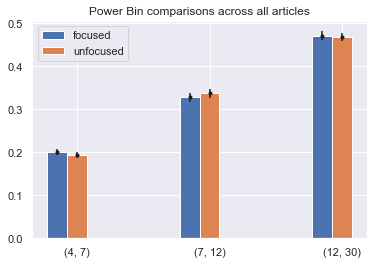

In [30]:
plt.title("Power Bin comparisons across all articles")

plotMultipleBarGraphs([focused_power_ratio_avg, unfocused_power_ratio_avg], 0.15, ["focused","unfocused"], intervals, error_values=[SEM_focused_power_ratio, SEM_unfocused_power_ratio])



In [31]:

# Write article data to files
ensureDirExists(article_results_directory)
writeToPickle(article_results, article_results_path)


ensureDirExists(article_results_sem_directory)
writeToPickle(article_sem_results, article_results_sem_path)

ensureDirExists(states_df_directory)
writeToPickle(states_df, states_df_path)

ensureDirExists(ustatistic_directory)
writeToPickle(mann_whitney_ustatistic_results, ustatistic_path)

ensureDirExists(pvalue_directory)
writeToPickle(mann_whitney_pvalue_results, pvalue_path)


print("Done!")
print(foldername, filename)


Done!
P001 part_P001_block_S004
